# Курсовой проект

Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

**Сдача проекта:**
Необходимо получить R2 > 0.6 на Private Leaderboard.
Укажите свой ник на kaggle
Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

**Рекомендации для файла с кодом (ipynb):**

Файл должен содержать заголовки и комментарии
Повторяющиеся операции лучше оформлять в виде функций
По возможности добавлять графики, описывающие данные (около 3-5)
Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
Весь проект должен быть в одном скрипте (файл ipynb).
При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна.
Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров.

**Подключение библиотек и скриптов**

In [244]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [245]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [246]:
TRAIN_DATASET_PATH = 'course_work/data/train.csv'
TEST_DATASET_PATH = 'course_work/data/test.csv'

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [247]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [248]:
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


In [249]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [250]:
train_df.shape[1]-1 == test_df.shape[1]

True

In [251]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

**Уменьшение объема памяти, который занимает датасет**

In [252]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [253]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [254]:
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


**Приведение типов**

In [255]:
train_df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [256]:
train_df = train_df.astype({"Id": str, "DistrictId": str})
train_df.dtypes

Id                 object
DistrictId         object
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

**Обработка пропусков**

**Распределение целевой переменной**

In [257]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0]

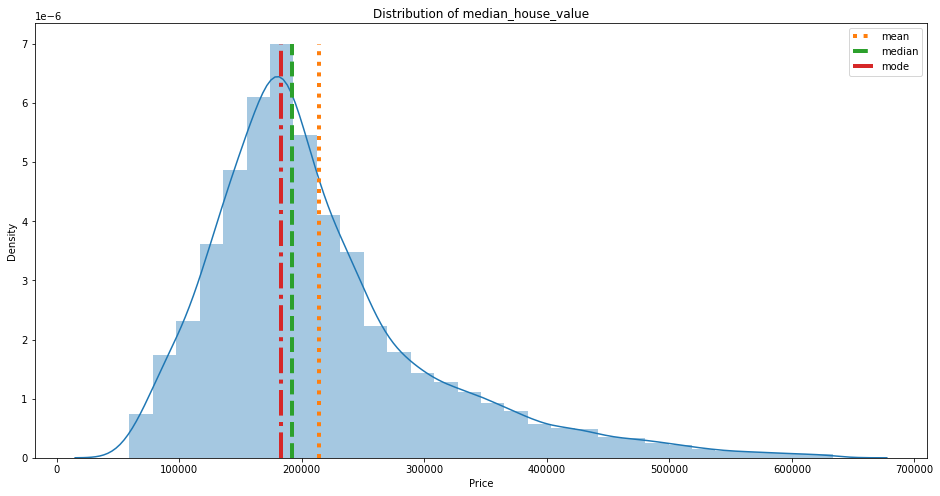

In [258]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=30)

y = np.linspace(0, 0.000007, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of median_house_value')
plt.legend()
plt.show()

In [259]:
square_m2 = (train_df['Price']/train_df['Square'])
square_m2


0       3854.958740
1       4567.491211
2       4915.149414
3       3291.591797
4       3788.892578
           ...     
9995    3902.328125
9996    4553.064941
9997    3319.714355
9998    4164.786133
9999    5656.401855
Length: 10000, dtype: float32

In [260]:
print(square_m2.max())

230463.53125


In [261]:
target_mean = round(square_m2.mean(), 2)
target_median = square_m2.median()
target_mode = square_m2.mode()[0]
print('Target_mean of square_m2: ', target_mean)
print('Target_median of square_m2: ', target_median )
print('Target_mode of square_m2: ', target_mode)

Target_mean of square_m2:  3988.38
Target_median of square_m2:  3910.05224609375
Target_mode of square_m2:  2710.1594


**Анализ признаков**

**Количественные признаки**

In [262]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,0.839523,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [263]:
df_num_features = train_df.select_dtypes(include=['float64', 'float32', 'float16'])
df_num_features.drop('Price', axis=1, inplace=True)
df_num_features

,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,Ecology_1,Healthcare_1
0,2.0,47.981560,29.442751,6.0,9.0,0.089040,NaN
1,3.0,65.683640,40.049541,8.0,9.0,0.000070,240.0
2,2.0,44.947952,29.197611,0.0,12.0,0.049637,229.0
3,2.0,53.352982,52.731510,9.0,17.0,0.437885,1084.0
4,1.0,39.649193,23.776169,7.0,12.0,0.012339,2078.0
...,...,...,...,...,...,...,...
9995,2.0,50.401787,30.476204,5.0,5.0,0.135650,350.0
9996,1.0,41.521545,20.539215,9.0,13.0,0.000000,NaN
9997,1.0,47.939007,NaN,1.0,16.0,0.072158,NaN
9998,2.0,43.602562,33.840149,8.0,5.0,0.307467,325.0


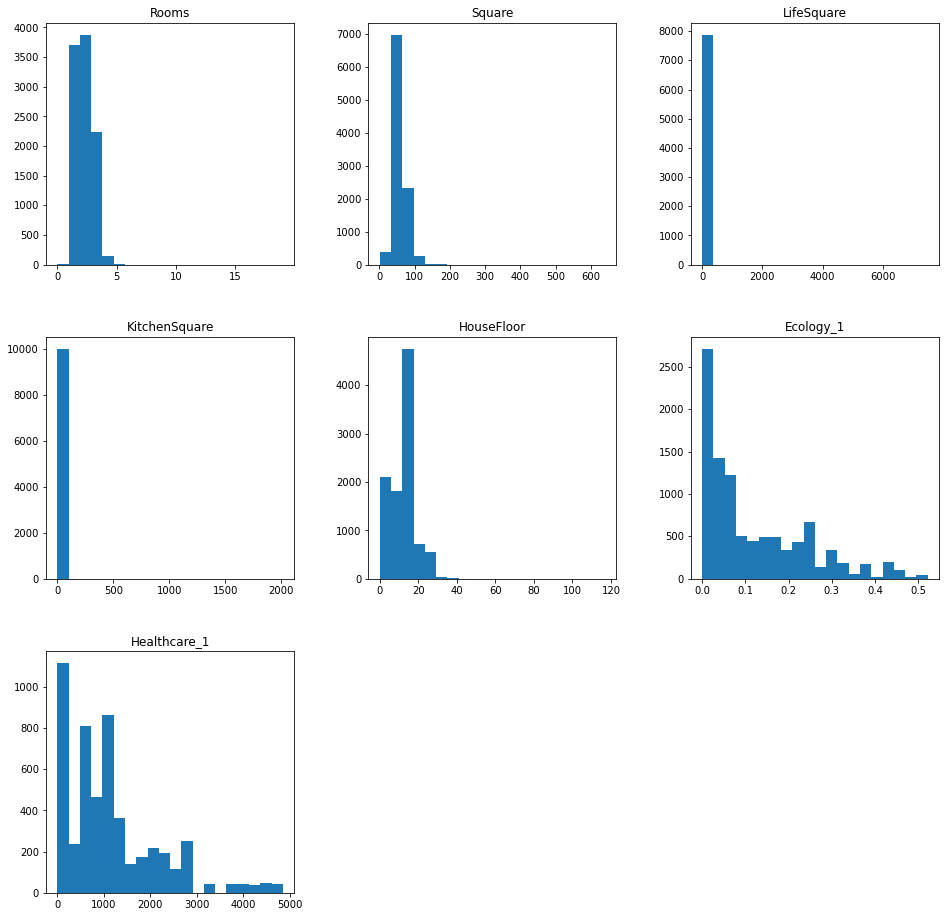

In [264]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

**Номинативные переменные**

In [265]:
df_obj_features = train_df.select_dtypes(include='object').columns.tolist() + train_df.select_dtypes(include='category').columns.tolist()
df_obj_features

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [266]:
for key in df_obj_features:
    print(f"{key}: \n{train_df[key].value_counts()} \n")

Id: 
14991    1
3628     1
1951     1
12914    1
4762     1
        ..
16439    1
10658    1
15285    1
4956     1
11192    1
Name: Id, Length: 10000, dtype: int64 

DistrictId: 
27     851
1      652
23     565
6      511
9      294
      ... 
205      1
117      1
209      1
207      1
174      1
Name: DistrictId, Length: 205, dtype: int64 

Ecology_2: 
B    9903
A      97
Name: Ecology_2, dtype: int64 

Ecology_3: 
B    9725
A     275
Name: Ecology_3, dtype: int64 

Shops_2: 
B    9175
A     825
Name: Shops_2, dtype: int64 



**Обработка выбросов**

In [267]:
for key in df_num_features:
    print(f"{key}: \n{train_df[key].value_counts()} \n")

Rooms: 
2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64 

Square: 
65.285133    2
44.482914    2
80.794792    2
81.867165    2
37.498161    2
            ..
39.987534    1
62.533691    1
79.181877    1
68.142555    1
39.826721    1
Name: Square, Length: 9995, dtype: int64 

LifeSquare: 
33.859653    2
36.358482    1
31.681011    1
23.124699    1
19.830021    1
            ..
34.304031    1
22.995483    1
32.790993    1
33.152943    1
53.892090    1
Name: LifeSquare, Length: 7886, dtype: int64 

KitchenSquare: 
1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
112.0        2
51.0         2
58.0         2
37.0         2

In [268]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 5), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 5, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        # Если этаж больше этажности здания
        X.loc[X["Floor"] > X["HouseFloor"], "Floor"] = X["HouseFloor"]
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        # Если жилая площадь больше общей площади
        X.loc[X["Square"] - 5 < X["LifeSquare"], "LifeSquare"] = X["Square"] - 5
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

In [269]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

In [270]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [271]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,1,33,7976,5,NaN,0,11,1,184966.937500,22
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,1,46,10309,1,240.0,1,16,1,300009.437500,87
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,...,1,34,7759,0,229.0,1,3,1,220925.906250,174
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,1,23,5735,3,1084.0,0,5,1,175616.234375,179
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,1,35,5776,1,2078.0,2,4,1,150226.531250,97


In [272]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [273]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

In [274]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.437500
1,0,2.0,176210.812500
2,0,3.0,300610.375000
3,1,1.0,146735.671875
4,1,2.0,202706.093750


In [275]:
med_price_by_district.shape

(675, 3)

In [276]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,NaN,0,11,1,184966.937500,22,0,207786.125000
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,10309,1,240.0,1,16,1,300009.437500,87,0,300009.437500
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,...,7759,0,229.0,1,3,1,220925.906250,174,1,263206.218750
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,5735,3,1084.0,0,5,1,175616.234375,179,1,166809.671875
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2078.0,2,4,1,150226.531250,97,0,158539.062500


In [277]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [278]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       2
1       2
2       2
3       2
4       3
       ..
9995    2
9996    3
9997    3
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [279]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)

0        (5, 9]
1        (5, 9]
2        (5, 9]
3        (5, 9]
4       (9, 15]
         ...   
9995     (5, 9]
9996    (9, 15]
9997    (9, 15]
9998     (0, 3]
9999     (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [280]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,NaN,0,11,1,184966.937500,22,0,207786.125000,3,3
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,240.0,1,16,1,300009.437500,87,0,300009.437500,3,3
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,...,229.0,1,3,1,220925.906250,174,1,263206.218750,3,3
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,1084.0,0,5,1,175616.234375,179,1,166809.671875,3,3
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,2078.0,2,4,1,150226.531250,97,0,158539.062500,3,4


In [281]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,380359.12500
1,1,2,321497.43750
2,1,3,368718.25000
3,1,4,400715.43750
4,2,1,467230.53125


In [282]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,0,11,1,184966.937500,22,0,207786.125000,3,3,188098.156250
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,1,16,1,300009.437500,87,0,300009.437500,3,3,188098.156250
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,...,1,3,1,220925.906250,174,1,263206.218750,3,3,188098.156250
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,0,5,1,175616.234375,179,1,166809.671875,3,3,188098.156250
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,2,4,1,150226.531250,97,0,158539.062500,3,4,185190.984375


In [283]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
            
        # Более менее новый дом или нет
        X["IsNewHouse"] = 0
        X.loc[X["HouseYear"] > 2000, "IsNewHouse"] = 1
        
        # Первый или последний этаж
        X["IsUpperOrLowerFloor"] = 0
        X.loc[(X["Floor"] == 1) | (X["Floor"] == X["HouseFloor"]), "IsUpperOrLowerFloor"] = 1
        
        
        # Если этажность здания больше 5 этажей, тогда должен иметься лифт
        X["HasPassengerLift"] = 0
        X.loc[X["HouseFloor"] > 5, "HasPassengerLift"] = 1
        
        # Если дом до 1980, есть возможность поломки или протечки труб
        X["PossibilityFailure"] = 0
        X.loc[X["HouseYear"] < 1980, "PossibilityFailure"] = 1
        
        # Размер квартиры: большая, средняя или маленькая
        X["FlatSize"] = 0
        X.loc[(X["Square"] > 50) & (X["Square"] < 100), "FlatSize"] = 1
        X.loc[X["Square"] > 100, "FlatSize"] = 2
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

In [284]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [285]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear', 
                     "year_cat", "floor_cat", "IsNewHouse", "IsUpperOrLowerFloor", "HasPassengerLift", 
                     "PossibilityFailure", "FlatSize"]

target_name = 'Price'

**Разбиение на train и test**

In [286]:
train_df = reduce_mem_usage(pd.read_csv(TRAIN_DATASET_PATH))
test_df = reduce_mem_usage(pd.read_csv(TEST_DATASET_PATH))

X = train_df.drop(columns=target_name)
y = train_df[target_name]

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


In [287]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [288]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

In [289]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 34), (3300, 34), (5000, 34))

In [290]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [291]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

**Построение модели**

Train R2:	0.842
Test R2:	0.706


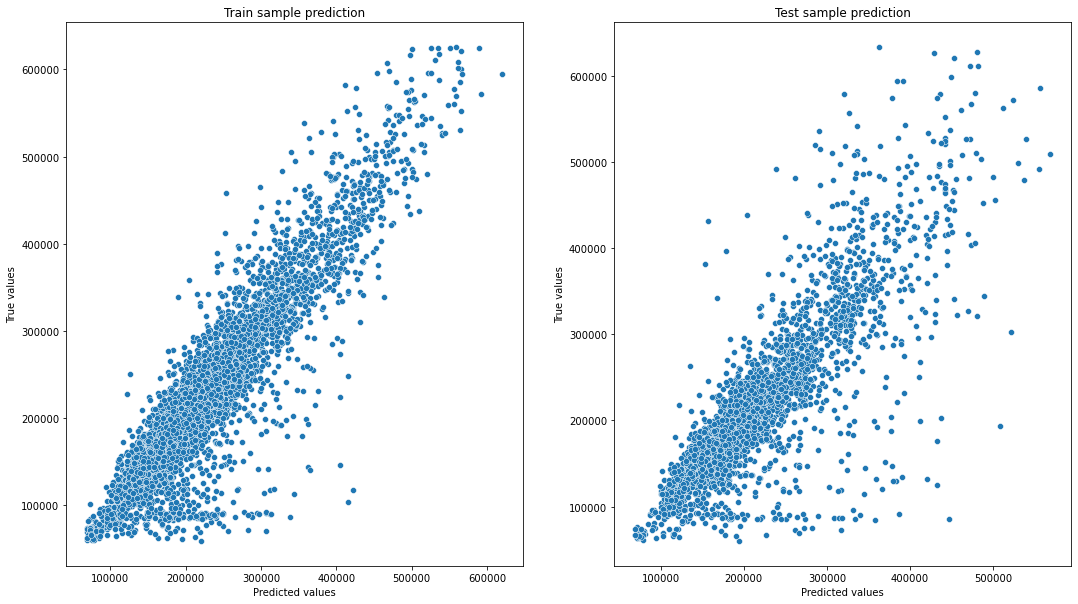

In [292]:
from sklearn.ensemble import StackingRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

lr = LinearRegression()

br = BaggingRegressor(DecisionTreeRegressor(max_depth=5, criterion='mse',
                                              min_samples_leaf=15, random_state=100), n_estimators=50, random_state=100)

gb = GradientBoostingRegressor(criterion='mse',
                                 max_depth=5,
                                 min_samples_leaf=15,
                                 random_state=100,
                                 n_estimators=50)
gb.fit(X_train, y_train)

stack = StackingRegressor([('baggingR', br), ('boostingR', gb)], final_estimator=lr)
stack.fit(X_train, y_train)
y_train_pred = stack.predict(X_train)
y_valid_pred = stack.predict(X_valid)
evaluate_preds(y_train, y_train_pred, y_valid, y_valid_pred)

In [293]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
23,MedPriceByDistrict,0.708030
1,Square,0.135021
20,DistrictSize,0.029312
12,Social_3,0.018950
2,LifeSquare,0.013409
24,MedPriceByFloorYear,0.012868
5,HouseFloor,0.012378
6,HouseYear,0.011346
11,Social_2,0.010876
3,KitchenSquare,0.009961


In [294]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']
new_feature_names = ['HouseFloor_outlier', 'LifeSquare_nan', 'DistrictSize', 'IsDistrictLarge', 
                     'MedPriceByFloorYear', "year_cat", "floor_cat", "IsNewHouse", 
                     "IsUpperOrLowerFloor", "HasPassengerLift", "FlatSize"]

In [295]:
train_df = reduce_mem_usage(pd.read_csv(TRAIN_DATASET_PATH))
test_df = reduce_mem_usage(pd.read_csv(TEST_DATASET_PATH))

X = train_df.drop(columns=target_name)
y = train_df[target_name]

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


In [296]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [297]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

In [298]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 34), (3300, 34), (5000, 34))

In [299]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

Train R2:	0.817
Test R2:	0.72


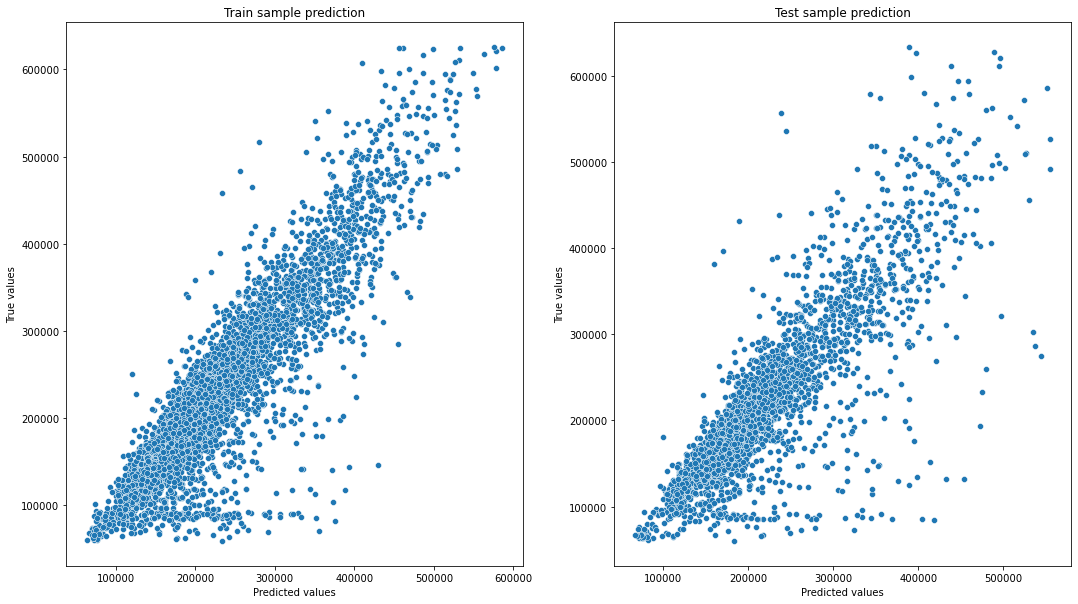

In [300]:
from sklearn.ensemble import StackingRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

br = BaggingRegressor(DecisionTreeRegressor(max_depth=5, criterion='mse',
                                              min_samples_leaf=15, random_state=100), n_estimators=50, random_state=100)

gb = GradientBoostingRegressor(criterion='mse',
                                 max_depth=5,
                                 min_samples_leaf=15,
                                 random_state=100,
                                 n_estimators=50)
gb.fit(X_train, y_train)

stack = StackingRegressor([('baggingR', br), ('boostingR', gb)], final_estimator=lr)
stack.fit(X_train, y_train)
y_train_pred = stack.predict(X_train)
y_valid_pred = stack.predict(X_valid)
evaluate_preds(y_train, y_train_pred, y_valid, y_valid_pred)

In [301]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.491443
17,DistrictSize,0.263820
11,Social_3,0.048105
7,Ecology_1,0.037401
0,Rooms,0.027734
19,MedPriceByFloorYear,0.024618
10,Social_2,0.020864
9,Social_1,0.017631
2,LifeSquare,0.015134
6,HouseYear,0.012220


In [302]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_3,Social_1,...,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByFloorYear,year_cat,floor_cat,IsNewHouse,IsUpperOrLowerFloor,HasPassengerLift,FlatSize
0,2.0,49.882645,33.432781,6.0,6.0,14.0,1972,0.310199,1,11,...,0,106.0,1,192118.968750,2,2.0,0,0,1,0
1,2.0,69.263184,63.263184,3.0,1.0,1.0,1977,0.075779,1,6,...,1,79.0,0,178966.187500,2,0.0,0,1,0,1
2,1.0,13.597818,8.597818,12.0,2.0,5.0,1909,0.000000,1,30,...,0,3.0,0,391217.281250,0,0.0,0,0,0,0
3,2.0,73.046608,51.940842,9.0,22.0,22.0,2007,0.101872,1,23,...,0,66.0,0,259213.140625,4,4.0,1,1,1,1
4,1.0,47.527111,42.527111,3.0,17.0,17.0,2017,0.072158,1,2,...,0,578.0,1,206647.250000,5,4.0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,3.0,67.133911,50.809795,6.0,5.0,9.0,1973,0.000170,1,36,...,0,88.0,0,186453.109375,2,1.0,0,0,1,1
4996,1.0,40.198471,21.807060,10.0,12.0,17.0,2017,0.007122,1,1,...,0,445.0,1,176184.984375,5,3.0,1,0,1,0
4997,3.0,77.842178,48.282623,9.0,22.0,22.0,1989,0.090799,1,74,...,0,41.0,0,260902.750000,3,4.0,0,1,1,1
4998,2.0,81.305222,75.305222,3.0,4.0,13.0,1977,0.072158,1,2,...,1,153.0,1,186453.109375,2,1.0,0,0,1,1


In [303]:
submit = reduce_mem_usage(pd.read_csv('Курсовая/sample_submission.csv'))
submit

Memory usage of dataframe is 0.08 MB
Memory usage after optimization is: 0.03 MB
Decreased by 62.4%


,Id,Price
0,725,200000.0
1,15856,200000.0
2,5480,200000.0
3,15664,200000.0
4,14275,200000.0
...,...,...
4995,8180,200000.0
4996,4695,200000.0
4997,5783,200000.0
4998,4780,200000.0


In [304]:
predictions = stack.predict(test_df)
predictions

array([154902.28941372, 236305.73187643, 306959.07882441, ...,
       349735.53149376, 211165.73285681, 187435.4136803 ])

In [305]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,725,154902.289414
1,15856,236305.731876
2,5480,306959.078824
3,15664,350658.233406
4,14275,140223.265959


In [306]:
submit.to_csv('my_submit.csv', index=False)